# Non-Generation-Based Evolution Strategy (NGBES) Optimizer

Conventional "Evolution Strategy" (ES) optimization technique involves generations. This substantially limits the scalability potential. Using the "generation" approach one has to wait until the whole generation-loop is processed. Only then computations for the next generation can resume. Thus, only partial parallelization (within the generation loop) is possible. But imagine, if one CPU is significantly slower than the others. Then all fast CPUs will be idling at the end of the generation-loop, waiting for the slow one to finish.

"Non-Generation-Based Evolution Strategy" (NGBES) optimizer uses the concept of a "pool"(or a table) of individuals and avoids the notion of generations. This allows to get a great scalability win.

### Example
Let us optimize a 2D non-separable and highly multimodal function

$f(x, y) = -x\sin\left(\sqrt{\mid x-\left(y+47\right) \mid}\right)-(y+47)\sin\left(\sqrt{\mid (y+47)+0.5x\mid}\right)$

$-600\leq x \leq 1000$
<br>
$-600\leq y \leq 1100$
<br><br>

This function is known as $\bf{F101}$, which is taken from "Parallel Problem Solving from Nature - PPSN IX" by Runarsson et al., 2006.

Let us visualize this $\bf{F101}$ function...

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import Model.FitnessFunction.F101 as F101
from IPython.display import display
from time import sleep
import ipywidgets as widgets
%matplotlib notebook

In [2]:
def plot_objective_function(ax, x_min, x_max, y_min, y_max, N):

    x, y = np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N)
    X, Y = np.meshgrid(x, y)

    zs = np.array([F101.func([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    levels = np.linspace(0, 1700, 20)
    im = ax.contour(X, Y, Z, vmin=Z.min(), vmax=Z.max(), linewidths=np.linspace(0.8, 1.5, 6), levels=levels, zorder=1)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    cb = fig.colorbar(im)
    cb.ax.tick_params(labelsize=15) 
    cb.ax.get_children()
    lines = cb.ax.get_children()[0]
    lines.set_linewidths(8)

<IPython.core.display.Javascript object>


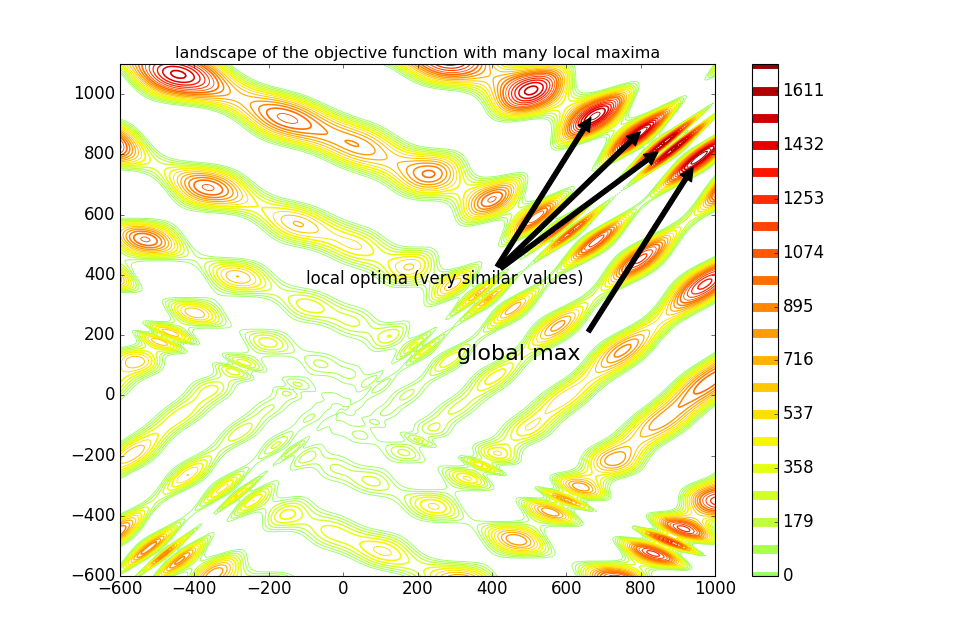

In [3]:
N = 300 # number of sampling points
x_min, x_max = -600, 1000.0
y_min, y_max =  -600.0, 1100.0

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
plot_objective_function(ax, x_min, x_max, y_min, y_max, N)

x_opt, y_opt = 956.49, 788.38  # location of the global maximum for the selected range
ax.annotate('global max', xy=(x_opt, y_opt), xytext=(x_opt-650, y_opt-670), 
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=20)
ax.annotate('', xy=(870, 830), xytext=(400, 400), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(820, 900), xytext=(400, 400), arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('', xy=(680, 950), xytext=(400, 400), arrowprops=dict(facecolor='black', shrink=0.05))
ax.text(-100, 370, r'local optima (very similar values)', fontsize=15)
ax.set_title("landscape of the objective function with many local maxima")

One can observe a number of local maxima. Some of these maxima are extremely narrow.
<br>
<br>
The global optimum(in the selected range) is located at:
<br>
$\left(x_{opt}, y_{opt}\right) = \left(956.49, 788.38\right)$
<br>
<br>
Near the global maximum there are three other local maxima.
Their values are very close to the value of the global one.
So the lanscape of this 2D function looks sufficiently complex for the optimization.

# Setting up the optimization

In [4]:
from Model.FitnessFunction.fitness import FitnessEvaluator
from Model.Optimizers.NonGenerationBased.parameters_ngb import ParamsNGB
from Model.BioMechanisms.mutation import StandardMutation
from Model.BioMechanisms.recombination import StandardRecombination
from Model.BioMechanisms.selection import RandomUniqueParentsSelection
from Model.Optimizers.NonGenerationBased.optimizer_ngb import OptimizerNGB
from Helpers.statistics_recorder import StatisticsRecorder
from Helpers.mappers import map_linearly_from_to

In [5]:
# set up parameters
search_spaces = np.array([[x_min, x_max], [y_min, y_max]])
max_fitness_calls = 4000
is_sigma_array = False
initial_sigma = 0.1
sigma_min = 0.01
sigma_max = 0.35
initial_table_size = 50
max_table_size = 50
num_recombined_parents = 2
record_after_iterations = 1
restarts_num = 1

params = ParamsNGB(search_spaces.shape[0], search_spaces, max_fitness_calls, 
                   is_sigma_array, initial_sigma, initial_table_size, max_table_size)

# fitness object (F101 function)
fitness_object = FitnessEvaluator(F101.func)

# selection, recombination and mutation objects
selection = RandomUniqueParentsSelection(num_recombined_parents).select_random_unique_parents
recombination = StandardRecombination.recombine
mutation = StandardMutation(params.num_params, sigma_min, sigma_max).mutate

# optimization engine
statistics_recorder = StatisticsRecorder(record_after_iterations)  # or None to disable
engine = OptimizerNGB(params, selection, recombination, mutation, statistics_recorder)

Now we can launch the optimization

In [6]:
optimization_results = engine.optimization_start(fitness_object)

let's now see how the population evolves as the optimization progresses

In [7]:
def plot_population(ax, table):
    marker_sigma_min = 0.1
    marker_sigma_max = 0.35
    plot_marker_min = 0.2
    plot_marker_max = 0.35
    for entry in table:
        mapped_params = map_linearly_from_to(entry.params, [0.0, 1.0], search_spaces)
        avrg_sigma = np.mean(entry.sigma)
        if avrg_sigma < marker_sigma_min:
            plot_marker_size = plot_marker_min
        elif avrg_sigma > marker_sigma_max:
            plot_marker_size = plot_marker_max
        else:
            plot_marker_size = avrg_sigma
        ax.plot(mapped_params[0], mapped_params[1], 'o', color='grey', markersize=30.0*plot_marker_size, alpha=0.5)

Widget Javascript not detected.  It may not be installed or enabled properly.


<IPython.core.display.Javascript object>


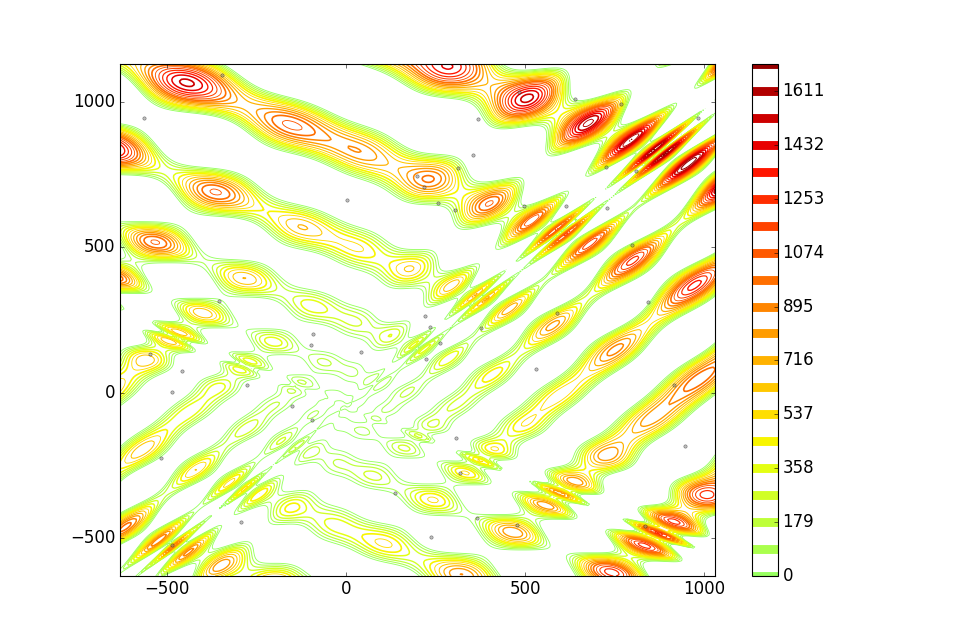

In [8]:
# prepare widgets
iteration_slider = widgets.IntSlider(1, min = 0, max = len(optimization_results[1].records), step=50, description='Iteration')
display(iteration_slider)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

def plot_optimization_at_moment(value):
    fig.clf()
    ax = fig.add_subplot(111)
    offset = 30
    plot_objective_function(ax, x_min-offset, x_max+offset, y_min-offset, y_max+offset, N)
    plot_population(ax, optimization_results[1].records[value.new])
    fig.canvas.draw()

iteration_slider.observe(plot_optimization_at_moment, names = 'value')
iteration_slider.value = 0

###  Evolution of parameters during optimization

<IPython.core.display.Javascript object>


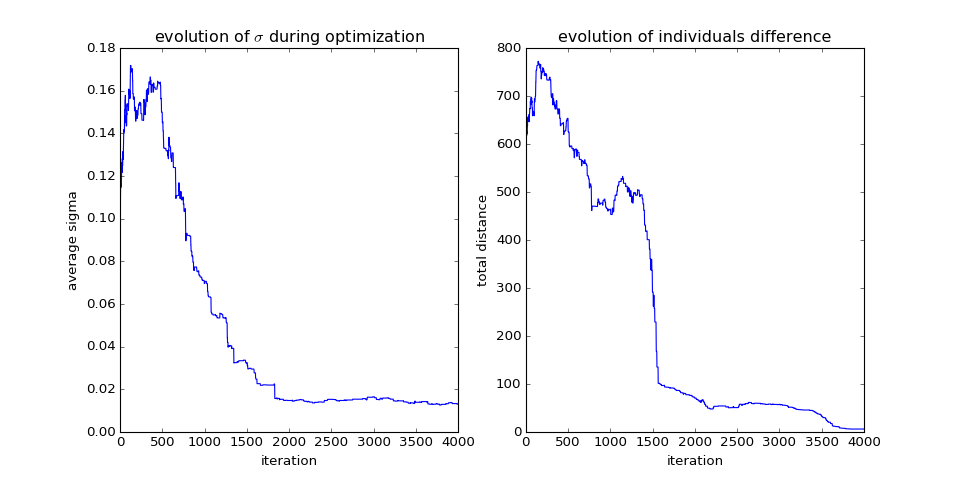

In [9]:
def plot_params_evolution():
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    # sigma evolution (adaption of the endogenous parameter)
    ax[0].set_xlabel("iteration")
    ax[0].set_ylabel("average sigma")
    ax[0].set_title(r"evolution of " +"$\sigma$" + " during optimization")
    ax[0].plot(np.arange(0, max_fitness_calls + 1, 1), 
               optimization_results[1].get_avg_sigma_all_records())
    
    # evolution of distance between individuals
    ax[1].set_xlabel("iteration")
    ax[1].set_ylabel("total distance")
    ax[1].set_title(r"evolution of individuals difference")
    ax[1].plot(np.arange(0, max_fitness_calls + 1, 1), 
               optimization_results[1].get_population_distances_all_records())

plot_params_evolution()    

One can say that optimization converged when two conditions hold:
<br>
1) $\sigma \rightarrow 0$
<br>
2) D $\rightarrow 0$ (difference or distance between individuals)
<br>
D = $\sum\limits_{i=1}^{M} d_i$, M - table size
<br>
$d_i=\sum\limits_{j\neq i}^{M}\mid \mid \vec{x_j} - \vec{x_i} \mid \mid$, here $\vec x_i=(x_1^i, \dots, x^i_N)$ is the parameter vector of i$^\mathrm{th}$ individual in a table

Condition (1) implies that the mutation strength very low. Thus, a newborn offspring represents an almost identical copy of his parents. At this point the landscape of the objective function is not explored any further.
<br>
Condition (2) shows how much difference there is between all individuals stored in the table. Once all individuals become identical (D $\rightarrow 0$) and mutation strength is small ($\sigma \rightarrow 0$) the optimization converged to some local (or global) optimum.